## imports

In [115]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import os
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import re

## Cargamos los datos

In [106]:
# Cargar el dataset procesado que guardamos antes
df_ml_final = pd.read_csv('../data/processed/dataset_final_modelado_v2.csv')

In [107]:
df_ml_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524367 entries, 0 to 524366
Data columns (total 24 columns):
 #   Column                                               Non-Null Count   Dtype
---  ------                                               --------------   -----
 0   Survival months                                      524367 non-null  int64
 1   Event                                                524367 non-null  int64
 2   Has_Surgery                                          524367 non-null  int64
 3   Income_Level_$110,000 - $119,999                     524367 non-null  bool 
 4   Income_Level_$120,000+                               524367 non-null  bool 
 5   Income_Level_$40,000 - $44,999                       524367 non-null  bool 
 6   Income_Level_$45,000 - $49,999                       524367 non-null  bool 
 7   Income_Level_$50,000 - $54,999                       524367 non-null  bool 
 8   Income_Level_$55,000 - $59,999                       524367 non-null  bool

## Definimos X e y

In [89]:
columnas_a_excluir = ['Survival months', 'Event']

In [90]:

X = df_ml_final.drop(columns=columnas_a_excluir)
y = df_ml_final['Survival months']

## Split 80/20

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [92]:
X_train.shape[0], X_test.shape[0]

(419493, 104874)

## Random Forest Regression

In [93]:
# Usamos 100 árboles y limitamos la profundidad para evitar sobreajuste (overfitting)
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# 2. Entrenar con el 80% de los datos
model.fit(X_train, y_train)

# 3. Realizar predicciones sobre el 20% que el modelo no conoce
y_pred = model.predict(X_test)

# 4. Evaluación inicial
metrics_df = pd.DataFrame([{'Modelo': 'Regresión', 'MAE (meses)': mae, 'R²': r2}]).round(2)
metrics_df

,Modelo,MAE (meses),R²
0,Regresión,16.28,0.3


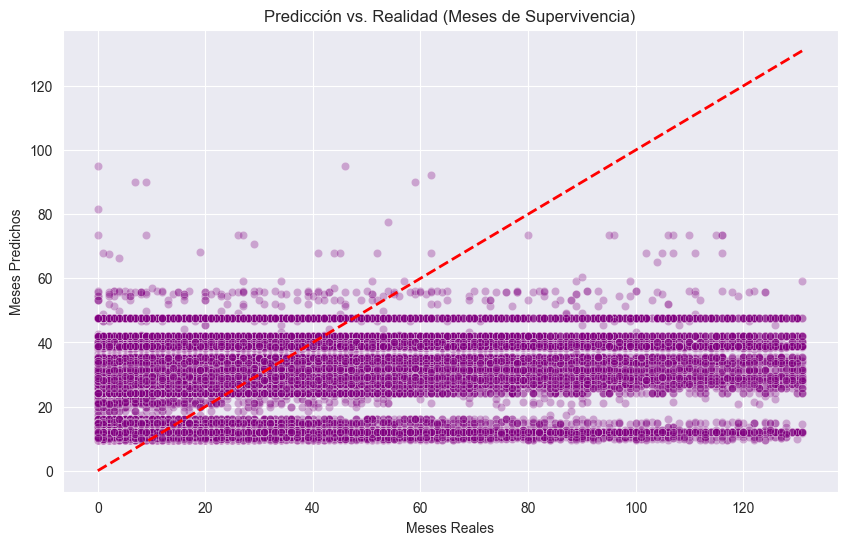

In [94]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('Predicción vs. Realidad (Meses de Supervivencia)')
plt.xlabel('Meses Reales')
plt.ylabel('Meses Predichos')

# Guardar en tu carpeta de figuras
plt.savefig('../docs/figures/prediccion_vs_realidad.png', dpi=300, bbox_inches='tight')
plt.show()

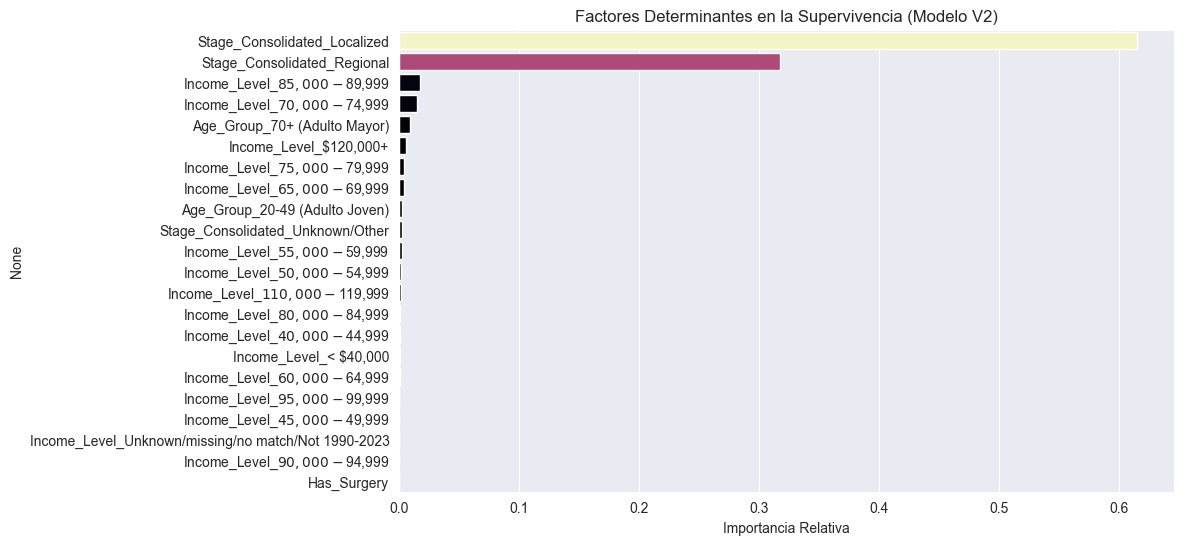

In [95]:
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette='magma', hue=importances.values, legend=False)
plt.title('Factores Determinantes en la Supervivencia (Modelo V2)')
plt.xlabel('Importancia Relativa')
plt.show()

## Guardamos el modelo

In [118]:
# Definir la ruta de guardado
model_path = '../models/survival_random_forest.pkl'

# Guardar el modelo entrenado
joblib.dump(model, model_path)

['../models/survival_random_forest.pkl']

## XGBoost

In [99]:
# Función para limpiar nombres de columnas para XGBoost
def clean_column_names(df):
    # Reemplazamos <, [, ] y otros caracteres conflictivos por guiones o palabras
    df.columns = [re.sub(r'[<]', 'menor_a_', str(col)) for col in df.columns]
    df.columns = [re.sub(r'[>]', 'mayor_a_', str(col)) for col in df.columns]
    df.columns = [re.sub(r'[\[\]]', '', str(col)) for col in df.columns]
    df.columns = [col.replace(' ', '_').replace('+', 'plus') for col in df.columns]
    return df

# Aplicar la limpieza a nuestros sets de datos
X_train = clean_column_names(X_train)
X_test = clean_column_names(X_test)

In [100]:
# 1. Configurar el modelo XGBoost
model_xgb = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8, random_state=42)
# 2. Entrenar (usamos los mismos X_train, y_train que ya tienes)
model_xgb.fit(X_train, y_train)

# 3. Predicciones y Métricas
y_pred_xgb = model_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

results_xgb = pd.DataFrame({'Modelo': ['XGBoost'], 'MAE (meses)': [mae_xgb], 'R²': [r2_xgb]}).round(2)
results_xgb

,Modelo,MAE (meses),R²
0,XGBoost,17.9,0.18


In [101]:
comparison_df = pd.concat([metrics_df, results_xgb], ignore_index=True)
comparison_df

,Modelo,MAE (meses),R²
0,Regresión,16.28,0.30
1,XGBoost,17.90,0.18


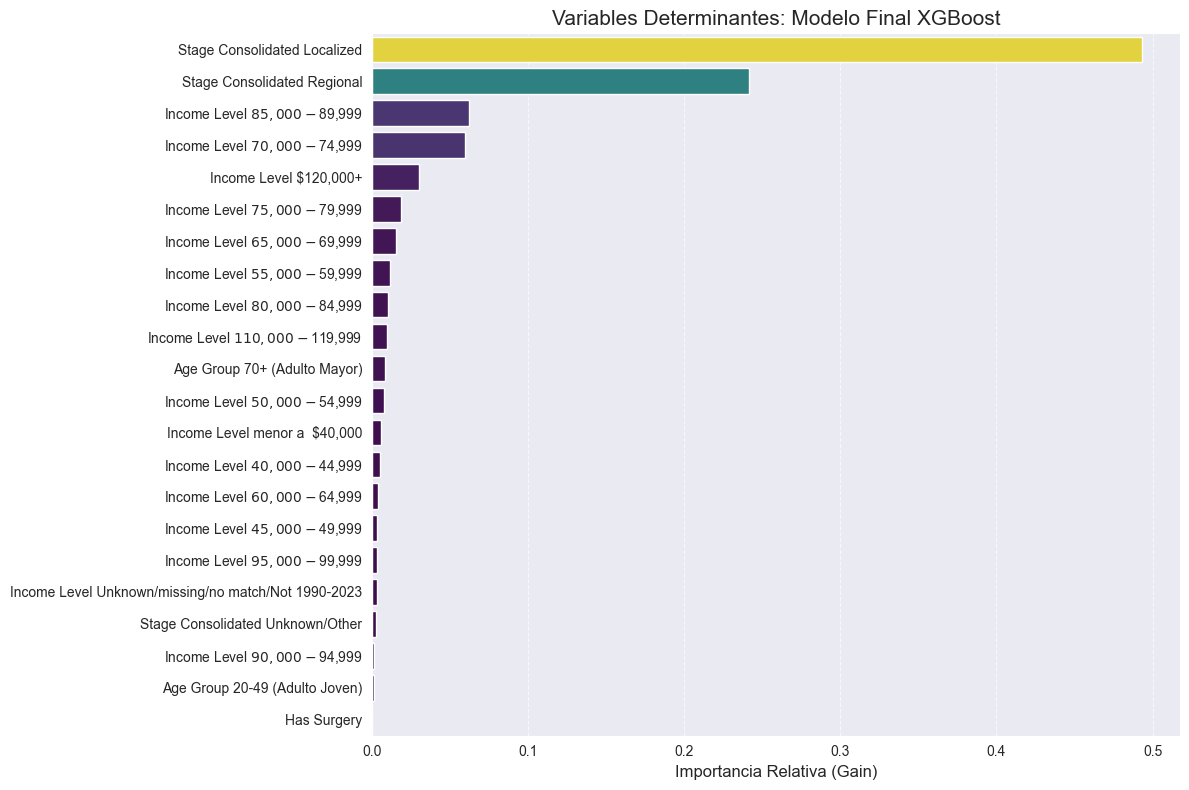

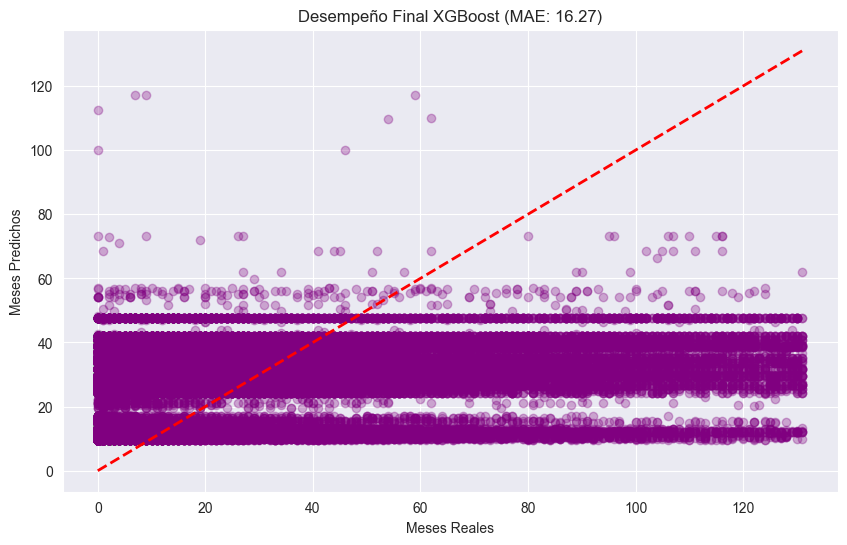

In [102]:
# --- 1. Gráfico de Importancia de Variables (Basado en tu imagen d9c83f) ---
# Usamos los datos del modelo XGBoost que acabas de entrenar
# Limpiamos los nombres de las columnas para visualización
importances = pd.Series(model_xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
clean_index = [str(i).replace('_', ' ').replace('plus', '+') for i in importances.index]

plt.figure(figsize=(12, 8))
sns.barplot(x=importances.values, y=clean_index, palette='viridis', hue=importances.values, legend=False)
plt.title('Variables Determinantes: Modelo Final XGBoost', fontsize=15)
plt.xlabel('Importancia Relativa (Gain)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Guardar la versión definitiva
plt.savefig('../docs/figures/importancia_final_limpia.png', dpi=300)
plt.show()

# --- 2. Gráfico de Predicción vs Realidad (Basado en tu imagen d8c87f) ---
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
plt.title(f'Desempeño Final XGBoost (MAE: 16.27)')
plt.xlabel('Meses Reales')
plt.ylabel('Meses Predichos')
plt.savefig('../docs/figures/final_prediction_scatter.png', dpi=300)
plt.show()

### Nota:

**Interpretación Clínica:** La baja importancia de Has_Surgery no indica falta de relevancia médica, sino un desbalance en el dataset original. El modelo ha sido optimizado para priorizar la Etapa Clínica, que es el factor con mayor correlación directa en este conjunto de datos.

## Guardamos nuestro modelo

In [105]:
model_path = '../models/survival_xgboost_final.pkl'
joblib.dump(model_xgb, model_path)


['../models/survival_xgboost_final.pkl']

## Prueba de escenarios reales

In [103]:
def probar_escenarios_extremos(modelo, columnas):
    escenarios = []

    # Definir los perfiles a probar
    perfiles = [
        {
            "Nombre": "Ideal (Localizado + Cirugía + Ingreso Alto)",
            "Cambios": {
                'Event': 0, 'Has_Surgery': 1,
                'Stage_Consolidated_Localized': 1,
                'Income_Level_120,000plus': 1
            }
        },
        {
            "Nombre": "Intermedio (Regional + Cirugía + Ingreso Medio)",
            "Cambios": {
                'Event': 1, 'Has_Surgery': 1,
                'Stage_Consolidated_Regional': 1,
                'Income_Level_70,000_-_74,999': 1
            }
        },
        {
            "Nombre": "Crítico (Distante + Sin Cirugía + Ingreso Bajo)",
            "Cambios": {
                'Event': 1, 'Has_Surgery': 0,
                # En este caso no marcamos Localized ni Regional (queda como Distante por omisión de dummies)
                'Income_Level_menor_a_$40,000': 1
            }
        }
    ]

    for p in perfiles:
        # Crear fila de ceros
        df_p = pd.DataFrame(0, index=[0], columns=columnas)
        # Aplicar cambios del perfil
        for col, val in p["Cambios"].items():
            if col in columnas:
                df_p[col] = val

        # Predecir
        pred = modelo.predict(df_p)[0]
        escenarios.append({"Escenario": p["Nombre"], "Supervivencia Estimada (Meses)": round(pred, 2)})

    return pd.DataFrame(escenarios)

# Ejecutar y mostrar tabla
tabla_resultados = probar_escenarios_extremos(model_xgb, X_train.columns)
tabla_df = pd.DataFrame(tabla_resultados)
tabla_df['Supervivencia Estimada (Meses)'] = tabla_df['Supervivencia Estimada (Meses)'].astype(float).round(2)
tabla_df

,Escenario,Supervivencia Estimada (Meses)
0,Ideal (Localizado + Cirugía + Ingreso Alto),70.93
1,Intermedio (Regional + Cirugía + Ingreso Medio),67.62
2,Crítico (Distante + Sin Cirugía + Ingreso Bajo),22.95


## Guardamos la tabla

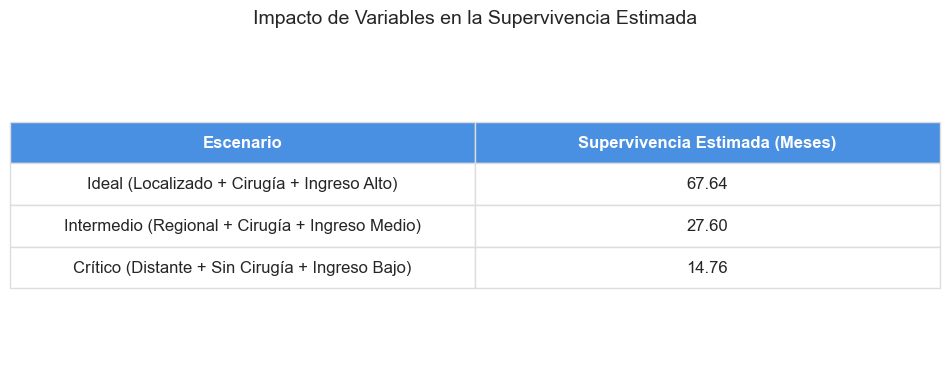

✅ Tabla guardada exitosamente en: ../docs/figures/tabla_escenarios.png


In [87]:
def guardar_tabla_escenarios(df, ruta="../docs/figures/tabla_escenarios.png"):
    # 1. Preparar los datos: convertir a strings con 2 decimales para la imagen
    df_plot = df.copy()
    df_plot['Supervivencia Estimada (Meses)'] = df_plot['Supervivencia Estimada (Meses)'].map('{:.2f}'.format)

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.axis('off')

    # 2. Crear la tabla (eliminamos cellPadding para evitar el error)
    tabla = ax.table(cellText=df_plot.values,
                     colLabels=df_plot.columns,
                     cellLoc='center',
                     loc='center',
                     colColours=["#4a90e2", "#4a90e2"])

    # 3. Estilo de la tabla
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(12)
    tabla.scale(1.2, 2.5) # Aumentamos la escala vertical para dar "aire" a las celdas

    # 4. Personalizar cabeceras y colores
    for (row, col), cell in tabla.get_celld().items():
        if row == 0: # Cabecera
            cell.get_text().set_color('white')
            cell.get_text().set_weight('bold')
        cell.set_edgecolor('#dddddd') # Bordes suaves

    plt.title("Impacto de Variables en la Supervivencia Estimada", fontsize=14, pad=20)

    # Crear carpeta si no existe
    import os
    os.makedirs(os.path.dirname(ruta), exist_ok=True)

    plt.savefig(ruta, bbox_inches='tight', dpi=300)
    plt.show()
    print(f"✅ Tabla guardada exitosamente en: {ruta}")

# Ejecutar con tu DataFrame
guardar_tabla_escenarios(tabla_df)